<a href="https://colab.research.google.com/github/philippe753/CNN_project/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import glob
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision 
from matplotlib import pyplot as plt
import gc
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, AveragePooling2D, Conv2D, MaxPooling2D
from keras.preprocessing import image
#from keras.optimizers import SGD, Adam
from keras.callbacks import TensorBoard
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, plot_roc_curve
from sklearn.neural_network import MLPClassifier
import pickle
import time
import cv2

In [ ]:
# unzip the data frame containing the celebraties images
!unzip "/content/drive/MyDrive/AI_dataset/img_align_celeba.zip"

In [ ]:
  # Importing data
  data_Y = pd.read_excel("/content/drive/MyDrive/AI_dataset/list_attr_celeba.xlsx")
  data_Y_columns = data_Y.iloc[0] # This contains the name of the features/columns of the dataframe.

  # Inspecting Data

  # plot of the first 5 columns of the raw data
  print("Raw data frame: \n")
  print(data_Y.head(5))


  data_Y = data_Y.replace(-1, 0) # Replace -1 for a 0.
  # Deleating the first row, since it contains it just a interger refereing to the total number of imgs.
  first_row = data_Y.iloc[0] #grab the first row for the header
  data_Y = data_Y[1:] #take the data less the header row
  data_Y.columns = first_row #set the header row as the df header
  print('New data frame: \n')
  data_Y.head(5)

In [ ]:
# download dataframe y

#pickle_out =  open("X.pickle", "bw")
#pickle.dump(training_data, pickle_out)
#pickle_out.close()

In [2]:
# Load data frame y
data_Y = pickle.load(open("/content/drive/MyDrive/AI_dataset/y.pickle","rb"))
#data_X = pickle.load(open("X.pickle","rb"))

## Description of our data Frame
As we can see bellow, most examples are not bold, do not have Clock shadow, do not have bangs, do not have blond hair, do not have double chin, do not have eyeglasses, do not have a Goatee, nor gray_hair, nor mustache, nor male skin, nor have a recending hairline, nor have rosy cheeks,nor side burns, nor wearing a hat, nor wearing a necktie.

The first model we'll learn is a  simple logisitc neural network to try to predict attrative and non attrative people. 

In [ ]:
data_Y.describe()

,#,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
count,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599
unique,202599,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,093762.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
freq,1,180083,148509,103833,161153,198052,171890,153814,155083,154127,172616,192287,161027,173796,190936,193140,189406,189883,194100,124209,110410,118165,104657,194182,179270,169158,145032,193898,146389,186436,189284,191150,104930,160377,137855,164323,192781,106884,177686,187867,156734


## Randomly pick m images to be the training set.
Every image is flattened from a 3 dimmensional array to a 1-dimensional array and then standarized.

In [ ]:
# randomly sample all the attractive people
data_Y_attractive = data_Y[data_Y["Attractive"] == 1]["Attractive"].sample(frac=1)
data_Y_attractive_idx = data_Y_attractive.index[0:]

data_Y_unattractive = data_Y[data_Y["Attractive"] == 0]["Attractive"].sample(frac=1)
#data_Y_unattractive = np.random.shuffle(data_Y_unattractive)
data_Y_unattractive_idx = data_Y_unattractive.index[0:]


In [ ]:
data_Y_attractive_idx[0]

166201

In [ ]:
# randomly sample all the attractive people
m_train = 1500
#m_test = 100
num_features = 116412
train_Y_attractive = data_Y_attractive.head(m_train)
#test_Y_attractive = data_Y_attractive.head(m_test)
attractive_idx = data_Y_attractive_idx[0:(m_train)] #+m_test
train_X_attractive = np.zeros((num_features, m_train))
#test_X_attractive = np.zeros((num_features, m_test))

# the same for the unattractive data set
train_Y_unattractive = data_Y_unattractive.head(m_train)
#test_Y_unattractive = data_Y_attractive.head(m_test)
unattractive_idx = data_Y_unattractive_idx[0:(m_train)]#+m_test
train_X_unattractive = np.zeros((num_features, m_train))
#test_X_unattractive = np.zeros((num_features, m_test))

img_path = np.sort(glob.glob("img_align_celeba/*.*"))

# randomly select samples from the attractive data set, and flatter it to an array
for i in range(0, m_train):
    img = cv2.imread(img_path[attractive_idx[i]])
    img_v = img.reshape((img.shape[0] * img.shape[1] * img.shape[2], 1))
    #if i < m_train:
        # for training set:
    train_X_attractive[:, i] = img_v[:, 0]
    #elif i>=m_train: 
    #    # for test set:
    #    test_X_attractive[:, (i-m_train)] = img_v[:, 0]

# randomly select samples from the unattractive data set, and flatter it to an array
for i in range(0, m_train):
    img = cv2.imread(img_path[unattractive_idx[i]])
    img_v = img.reshape((img.shape[0] * img.shape[1] * img.shape[2], 1))
    #if i < m_train: 
    train_X_unattractive[:, i] = img_v[:, 0]
    #elif i>=m_train:
    #    # for test set:
    #    test_X_unattractive[:, (i-m_train)] = img_v[:, 0]


In [ ]:
X = np.concatenate((train_X_attractive, train_X_unattractive), axis=1)
X.shape
y = np.reshape(np.concatenate((train_Y_attractive, train_Y_unattractive)), (1, -1))
############ TO DO ##############3
# try to make the sets in cointain both the attractive and unattractive .

In [ ]:
y = y
X = X
print("X_train shape is: " + str(X.shape))
print("y is: " + str(y.shape))

X_train shape is: (116412, 3000)
y is: (1, 3000)


In [ ]:
X_train_f, X_test_f, y_train_f,  y_test_f = train_test_split(X,
                                                             y,
                                                             test_size=0.1,
                                                             random_state=42)

In [ ]:
data_Y[data_Y['#'] == data_Y.iloc[(10)][0]]

,#,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
11,000011.jpg,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


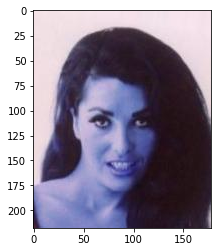

In [ ]:
img = cv2.imread(img_path[10])
plt.imshow(img)

### Randomly picking data - part 2

In [ ]:
m =  5000 # number of examples to train the models
m_test = 1000
num_features = 116412 #29103 num of features for each image
train_X = np.zeros((num_features, m))
train_Y = pd.DataFrame(data=data_Y.columns, columns=data_Y.columns)
test_X = np.zeros((num_features, m_test))
test_Y = pd.DataFrame(data=data_Y.columns, columns=data_Y.columns)
# random numbers to selecet the training examples from the data frame.
rand_num = np.random.choice(range(202599), (m + m_test), replace=False) 
img_path = np.sort(glob.glob("img_align_celeba/*.*"))

for i in range(0, m + m_test):
    img = cv2.imread(img_path[rand_num[i]])
    # flat image into an array.
    #img =  cv2.resize(img, (109, 89))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_v = img.reshape((img.shape[0] * img.shape[1] * img.shape[2], 1))
    if i < m:
        train_X[:, i] = img_v[:, 0]
        # find the equivalent samples in data_Y.
        train_Y = pd.concat([train_Y, data_Y[data_Y['#'] == data_Y.iloc[(rand_num[i])][0]]]) #, ignore_index=True)

    elif i>=m:
        # same as above but for the test set.
        test_X[:, (i-m)] = img_v[:, 0]
        test_Y = pd.concat([test_Y, data_Y[data_Y['#'] == data_Y.iloc[rand_num[i]][0]]]) #, ignore_index=True)

# Standardize data
train_X = train_X / 255.0
test_X = test_X / 255.0


# For now, we are only interested on the attribute attractive.
train_Y_attractive = train_Y['Attractive']
train_idx = train_Y_attractive.index[0:]
#train_Y_attractive = train_Y_attractive.values.reshape((1, -1))
test_Y_attractive = test_Y['Attractive']
test_idx = test_Y_attractive.index[0:]
#test_Y_attractive = test_Y_attractive.values.reshape((1, -1))

In [6]:
## Visualizing the training set. 
# Note that since our models were randomly chosen from the data frame, then this
# sample should be a good representation of the Data Frame.
print("train_X shape is: " + str(train_X.shape))
print("train_Y_attractive shape is: " + str(train_Y_attractive.shape))
print("test_X shape is: " + str(test_X.shape))
print("test_Y_attractive shape is: " + str(test_Y_attractive.shape))


train_X shape is: (29103, 5000)
train_Y_attractive shape is: (5000,)
test_X shape is: (29103, 1000)
test_Y_attractive shape is: (1000,)


## Dueling with Imbalance data
Note that over 51 percent of the data samples in the data frame are attractive people. Therfore, the deep neural network will be more bias towards predicting the that a particulat example is attractive.

In [7]:
num_attractive = len(train_Y_attractive[train_Y_attractive==1])
num_unattractive = len(train_Y_attractive[train_Y_attractive==0])
print("Percentage of attractive people in the data frame: {0:.2f}%.".format(np.mean(data_Y["Attractive"])*100)) 
print("Percentage of attractive people in the training data: {0:.2f}%.".format(np.mean(train_Y_attractive)*100)) 
print("number of attractive people in training set: {}".format(num_attractive))
print("number of unaattractive people in training set: {}".format(num_unattractive))

Percentage of attractive people in the data frame: 51.25%.
Percentage of attractive people in the training data: 50.30%.
number of attractive people in training set: 2515
number of unaattractive people in training set: 2485


To mitigate this problem, we'll implement weights to each class (in this case attractive and non attractive people)

In [9]:
# deleate attrative deta set from the training data so we get the we do not get
# an imbalanced data set.
def balance_data(train_X, train_y, rand_num, vector_form = True):
    train_y = train_y
    rand_num = rand_num.tolist()
    num_attractive = len(train_y[train_y==1])
    num_unattractive = len(train_y[train_y==0])
    attractive_idx = train_y[train_y == 1].index
    unattractive_idx = train_y[train_y == 0].index
    del_idx = []
    count=0

    if num_attractive > num_unattractive:
        del_num = num_attractive - num_unattractive
        randn_num = np.random.choice(range(num_attractive-del_num), (del_num), replace=False) 
        while num_attractive > num_unattractive:
            del_idx.append(rand_num.index(attractive_idx[randn_num[count]]-1))
            del_attractive = train_y[train_y == 1].index[randn_num[count]]
            del train_y[del_attractive]
            num_attractive = num_attractive - 1
            count +=1
        if vector_form == True:
            train_X_f = np.delete(train_X, del_idx, axis=1)
        else:
            train_X_f = np.delete(train_X, del_idx, axis=0)


    elif num_attractive < num_unattractive:
        del_num = num_unattractive - num_attractive
        randn_num = np.random.choice(range(num_unattractive-del_num), (del_num), replace=False) 
        while num_attractive < num_unattractive:
            del_idx.append(rand_num.index(unattractive_idx[randn_num[count]]-1))
            del_unattractive = train_y[train_y == 0].index[randn_num[count]]
            del train_y[del_unattractive]
            num_unattractive = num_unattractive - 1
            count += 1
        train_X_f = np.delete(train_X, del_idx, axis=1)
    else:
        train_X_f = train_X
    return train_X_f, train_y

In [ ]:
randn_num = np.random.choice(range(num_attractive-del_num), (del_num), replace=False) 
randn_num

In [9]:
# New training set:
print("Percentage of attractive people in the training data: {0:.2f}%.".format(np.mean(train_Y_attractive)*100)) 
print("number of attractive people in training set: {}".format(num_attractive))
print("number of unaattractive people in training set: {}".format(num_unattractive))
print("train_X_f shape: {}".format(train_X_f.shape))
print("train_Y_attractive shape: {}".format(train_Y_attractive.shape))

Percentage of attractive people in the training data: 50.00%.
number of attractive people in training set: 2485
number of unaattractive people in training set: 2485
train_X_f shape: (116412, 4970)
train_Y_attractive shape: (4970,)


Now we have the same number of attractive and unattractive people in our training data.

In [ ]:
print("Percentage of attractive people {0:.2f}%".format(np.mean(train_Y_attractive)*100))
print(train_Y_attractive.size) 

Percentage of attractive people 50.00%
1994


## Perceptron model to predict attractive and non-attractive people.

We will implement the most basic implementation of a neural network to see how good a single layer neural network can accurately predict if a person is attractive or not. 

In [10]:
train_X = train_X_f.T
train_X, test_X = balance_data(train_X, train_Y_attractive)
train_Y_attractive = np.array(train_Y_attractive, dtype=np.float).T
test_X = test_X.T
test_Y_attractive = np.array(test_Y_attractive, dtype=np.float).T
test_idx = np.array(test_idx, dtype=np.int)

In [9]:
print(train_X.shape)
print(train_Y_attractive.shape)
print(test_X.shape)
print(test_Y_attractive.shape)


(4912, 116412)
(4912,)
(1000, 116412)
(1000,)


In [21]:
max_iter = 100000 # add more 
eta0 = 0.1

ppn = Perceptron(#penalty = 'elasticnet',
                 max_iter=max_iter, 
                 eta0=eta0)

ppn.fit(train_X, train_Y_attractive)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=0.1,
           fit_intercept=True, max_iter=100000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [22]:
# Predict
y_pred_train = ppn.predict(train_X)
y_pred = ppn.predict(test_X)
y_pred = y_pred.astype(int)
# Accuracy of the test set
print("accuracy on the training set: {0:.2f}%",
      format(accuracy_score(train_Y_attractive,
                            y_pred_train)*100))

print("accuracy on the test set: {0:.2f}%",
      format(accuracy_score(test_Y_attractive,
                            y_pred)*100))

accuracy on the training set: {0:.2f}% 64.81481481481481
accuracy on the test set: {0:.2f}% 56.599999999999994


true positive prediction:


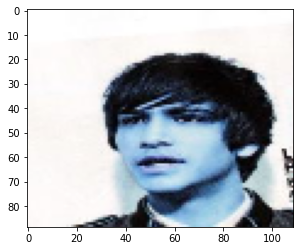

In [43]:
# plot some images of the test set for which the perceptron was correct
count_correct_atract = 0
for pred in y_pred:
    if y_pred[pred] == int(test_Y_attractive[pred]) and (
        int(test_Y_attractive[pred]) == 1 and count_correct_atract == 0):
        print('true positive prediction:')
        img = cv2.imread(img_path[test_idx[pred]])
        img =  cv2.resize(img, (109, 89))
        count_correct_atract +=1
        plt.imshow(img)
    if count_correct_atract > 0:
      break
    plt.show()

true negative prediction:


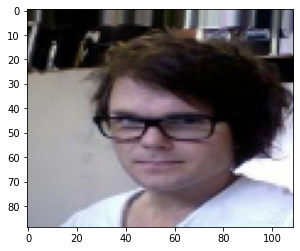

In [28]:
count_correct_unatract = 0
for pred in range(y_pred.size):
    if y_pred[pred] == int(test_Y_attractive[pred]) and (
      int(test_Y_attractive[pred]) == 0 and count_correct_unatract == 0):
        print('true negative prediction:')
        img = cv2.imread(img_path[test_idx[pred]])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img =  cv2.resize(img, (109, 89))
        count_correct_unatract +=1
        plt.imshow(img)
    if count_correct_unatract > 0:
        break
    plt.show()

Flase positive prediction:


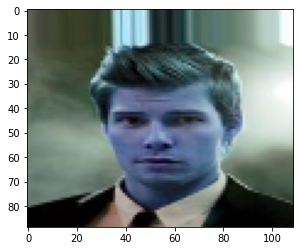

In [ ]:
count_incorrect_atract = 0
count = 0
for pred in range(y_pred.size):
    if y_pred[pred] != int(test_Y_attractive[pred]) and (
      int(test_Y_attractive[pred]) == 1 and count_incorrect_atract == 0):
        print('Flase positive prediction:')
        img = cv2.imread(img_path[test_idx[pred]])
        img =  cv2.resize(img, (109, 89))
        count_incorrect_atract +=1
        plt.imshow(img)
    if count_incorrect_atract > 0:
        break
    plt.show()
    

Flase negative prediction:


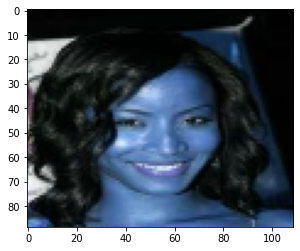

In [ ]:
count_incorrect_unatract = 0
for pred in range(y_pred.size):
    if y_pred[pred] != int(test_Y_attractive[pred]) and (
      int(test_Y_attractive[pred]) == 0 and count_incorrect_unatract == 0):
        print('Flase negative prediction:')
        img = cv2.imread(img_path[test_idx[pred]])
        img =  cv2.resize(img, (109, 89))
        count_incorrect_unatract +=1
        plt.imshow(img)
    if count_incorrect_unatract > 0:
        break
    plt.show()

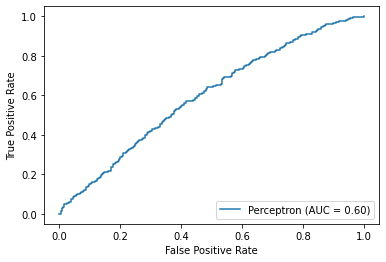

In [23]:
# ROC curve for the perceptron model
plot_roc_curve(ppn,  test_X, test_Y_attractive)

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = load_digits(return_X_y=True)

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

In [ ]:
plot_learning_curve(Perceptron(), "Learning curves (perceptron)", train_X, train_Y_attractive)

## Multilayer perceptron (MLP)

In [ ]:
#first_layer = int(np.ceil(num_features/32))

#plot_learning_curve(MLPClassifier(activation='logistic', solver='lbfgs'), "Learning curves (mlp)", train_X, train_Y_attractive)


In [ ]:
first_layer = int(np.ceil(num_features/16))
#hidden_layer_sizes=(first_layer, 20, 7, 5, 1)
#solver='lbfgs'
nn = MLPClassifier(activation='logistic', max_iter=100, solver='lbfgs', hidden_layer_sizes=(1000, 7, 1), random_state = 0)

nn.fit(train_X, train_Y_attractive)

In [11]:
# Predict
y_pred_train_nn = nn.predict(train_X)
y_pred_nn = nn.predict(test_X)
# Accuracy of the test set
print("accuracy on the training set: {0:.2f}%",
      format(accuracy_score(train_Y_attractive,
                            y_pred_train_nn)*100))

print("accuracy on the test set: {0:.2f}%",
      format(accuracy_score(test_Y_attractive,
                            y_pred_nn)*100))

accuracy on the training set: {0:.2f}% 51.241208109226314
accuracy on the test set: {0:.2f}% 57.699999999999996


In [17]:
print(test_Y_attractive.shape)

(1000,)


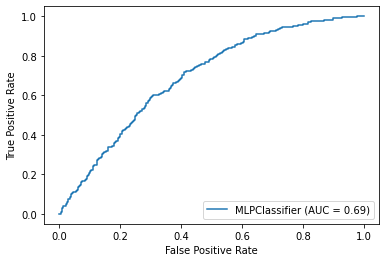

In [16]:
# ROC curve for the perceptron model
plot_roc_curve(nn,  test_X, test_Y_attractive)

In [ ]:
# Convolutional neural network
resnet = ResNet50(include_top=False, pooling='avg')
model = Sequential()
model.add(resnet)
model.add(Dense(1))
model.layers[0].trainable = False

_ = model(tf.zeros([1, 218,178, 3]))

model.summary()

## Convolutional Nueral Networks

In [ ]:
y = data_Y['Attractive'].head(5000)
y.describe()

In [ ]:
X = torch.FloatTensor(training_data) #pickle.load(open("X.pickle", "rb"))
y = data_Y['Attractive'].head(5000)

X = X/255.0

In [ ]:
print([X.shape[1:]])

## Convolutional Neural Network using Keras

For convolutional nueral networks, we do not need to pass vector the the nn, instead we pass a matrix containing the pixels of the image.

In [5]:
# Randomly selecting our data sets
m =  2000 # number of examples to train the models
m_test = 400
train_X = []
train_Y = pd.DataFrame(data=data_Y.columns, columns=data_Y.columns)
test_X = [] 
test_Y = pd.DataFrame(data=data_Y.columns, columns=data_Y.columns)
# random numbers to selecet the training examples from the data frame.
rand_num = np.random.choice(range(202599), (m + m_test), replace=False) 
img_path = np.sort(glob.glob("img_align_celeba/*.*"))

for i in range(0, m + m_test):
    img = cv2.imread(img_path[rand_num[i]])
    # flat image into an array.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array(img) 
    if i < m:
        train_X.append(img)
        train_Y = pd.concat([train_Y, data_Y[data_Y['#'] == data_Y.iloc[(rand_num[i])][0]]]) #, ignore_index=True)

    elif i>=m:
        test_X.append(img)
        test_Y = pd.concat([test_Y, data_Y[data_Y['#'] == data_Y.iloc[rand_num[i]][0]]]) #, ignore_index=True)

# standardize 
train_X = np.array(train_X).astype('float64')/255
test_X = np.array(test_X).astype('float64')/255


# For now, we are only interested on the attribute attractive.
train_y = train_Y['Attractive']
#train_idx = train_Y_attractive.index[0:]
#train_Y_attractive = train_Y_attractive.values.reshape((1, -1))
test_y = test_Y['Attractive']
#test_idx = test_Y_attractive.index[0:]
#test_Y_attractive = test_Y_attractive.values.reshape((1, -1))

In [57]:
print("percentage of attractive people: {}% ".format(np.mean(train_y)*100))
print(len(test_y))

percentage of attractive people: 50.0% 
2000


In [10]:
# balance data:
train_X, test_y = balance_data(train_X, train_y,rand_num, vector_form= False)
train_y = np.array(train_y)
test_y = np.array(test_y)

In [11]:
# New training set:
print("Percentage of attractive people in the training data: {0:.2f}%.".format(np.mean(train_y)*100)) 
print("train_X_f shape: {}".format(train_X.shape))
print("train_Y_attractive shape: {}".format(train_y.shape))

Percentage of attractive people in the training data: 50.00%.
train_X_f shape: (1920, 218, 178, 3)
train_Y_attractive shape: (1920,)


In [ ]:
## ---NEW SECTION---
# picking 75 and 75 attractive and unattractive people.
answers = data_Y['Attractive']
answers =answers.iloc[0:1050]
answers.mean()


0.5228571428571429

In [ ]:
from PIL import Image

imgs = []
#valid_images = [".jpg",".gif",".png",".tga"]

img_path = np.sort(glob.glob("img_align_celeba/*.*"))

for i in range(100):
    #img = cv2.imread(img_path[i])
    image = cv2.imread(img_path[i])
    img = np.array(image)
            
    imgs.append(img)

In [ ]:
images_tensor = torch.FloatTensor(imgs)
img_transpose = torch.transpose(images_tensor, 1, 3) #torch.reshape(images_tensor, (1050, 3, 218, 178))
img_transpose = img_transpose.transpose(2, 3)
img_transpose.size()

torch.Size([10, 3, 218, 178])

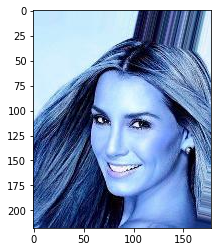

In [ ]:
# plot an image to make sure that everything is in order. Note that pythong plots images in gbr not in rbg.
tensor_img = img_transpose[10]/255
plt.imshow(tensor_img.permute(1, 2, 0))

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(41820, 418)
        self.fc2 = nn.Linear(418, 44)
        self.fc3 = nn.Linear(44, 5)
        self.fc4 = nn.Linear(5, 2)

    def forward(self, x):
        x=x
        # (1) Input later "x = x"
        # (2) Hidden conv1 layer
#         x = self.conv1(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))

        # (3) Hidden conv2 layer
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # (4) Hidden linear layer
        x = x.view(x.size(0),  41820)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

In [ ]:
model = Net()
model

In [ ]:
answers.astype('float64').values

In [ ]:
answers_train = torch.from_numpy(answers.astype('float64').values)
answers_train2 = answers_train.long()

img_transpose_train = img_transpose
img_transpose_train.size()

torch.Size([1050, 3, 218, 178])

In [ ]:
cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00000000000001)

In [ ]:
for step in range(20):
    models = model(img_transpose_train)
    cross_entropy = cross_entropy_loss(models, answers_train2)
    total_cost = cross_entropy 
    
    print(total_cost)

    optimizer.zero_grad()
    total_cost.backward()
    optimizer.step()

In [ ]:
_ , predicted = torch.max(models.data, 1)
predicted

In [ ]:
_ , predicted = torch.max(models.data, 1)

final = answers_train2.size(0)
correct = (predicted == answers_train2).sum()
print('- Accuracy: %f %%' % (100 * float(correct) / final))
print('- CE : %2.2f,' % (cross_entropy.item()))

# keras Model

In [ ]:
#images_tensor = np.array(imgs)
X = np.array(imgs).astype('float64')/255
y = np.array(answers_train2) #np.array(data_Y["Attractive"].head(1050))
print(X.shape)

In [54]:
# THIS WILL BE USE LATER TO ANALIZE THE CNN
# Tensorboard:
logdir = "/content/"
NAME = "Attractive-{}".format(int(time.time()))
tensorboard_callback = TensorBoard(log_dir=logdir+'logs/{}'.format(NAME))
#tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [55]:
print(train_X.shape)

(2000, 218, 178, 3)


In [9]:
model = Sequential()

model.add(Conv2D(64, (3,3), input_shape = train_X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))  #, strides=None, padding='valid', data_format='channels_first'))

model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation("relu"))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss="binary_crossentropy",
             optimizer="adam", 
             metrics=['accuracy'])

model.fit(train_X, train_y, batch_size=32,epochs=10, validation_split=0.1, callbacks =[tensorboard_callback])

ValueError: ignored

In [ ]:
dense_layers = [0, 1, 2]
layer_sizes = [32, 64, 128]
conv_layers = [1, 2, 3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size,  dense_layer, int(time.time()))
            tensorboard_callback = TensorBoard(log_dir=logdir+'logs/{}'.format(NAME))
            print(NAME)
            model = Sequential()

            model.add(Conv2D(64, (3,3), input_shape = X.shape[1:]))
            model.add(Activation("relu"))
            model.add(MaxPooling2D(pool_size=(2, 2)))  #, strides=None, padding='valid', data_format='channels_first'))

            for l in range(conv_layer-1):
                model.add(Conv2D(conv_layer, (3,3)))
                model.add(Activation("relu"))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())
            for l in range(dense_layer):
                model.add(Dense(dense_layer))
                model.add(Activation("relu"))
 
            model.add(Dense(1))
            model.add(Activation('sigmoid'))

            model.compile(loss="binary_crossentropy",
                        optimizer="adam", 
                        metrics=['accuracy'])

            model.fit(X, y, batch_size=32,epochs=10, validation_split=0.1, callbacks =[tensorboard_callback])

In [ ]:
# Load tensorboard:
%tensorboard --logdir /content/